<a href="https://www.kaggle.com/code/youneseloiarm/mitsui-co-flaml-with-lags-sub-02?scriptVersionId=259568592" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

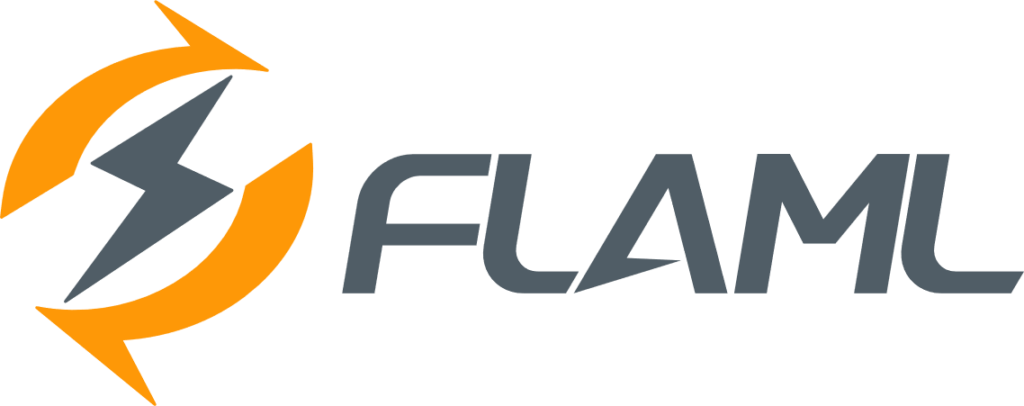

---

**In this notebook, we will use FLAML AutoML for a multi-target regression problem, leveraging lagged targets to predict 424 outputs. To speed up inference, we adopt the long-format multi-output prediction method, which is much faster than the standard multi-output approach.**

**You will also find several useful techniques in this notebook, including:**

* How to create lagged targets and use them in the prediction step
* How to run AutoML models offline (without internet access)
* How to build an optimized prediction function for API inference



---

In [1]:
!pip install --no-index --no-deps /kaggle/input/flaml-124/wheelhouse/FLAML-2.3.5-py3-none-any.whl
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Processing /kaggle/input/flaml-124/wheelhouse/FLAML-2.3.5-py3-none-any.whl


In [2]:
from flaml import AutoML
import kaggle_evaluation.mitsui_inference_server
from sklearn import *
import numpy as np
import pandas as pd
import polars as pl
import os, warnings
warnings.filterwarnings("ignore")

p = '/kaggle/input/mitsui-commodity-prediction-challenge/'
train = pd.read_csv(p+'train.csv')
trainl = pd.read_csv(p+'train_labels.csv')
traint = pd.read_csv(p+'target_pairs.csv')

In [3]:
trainl = trainl.fillna(0)

In [4]:
target_lag_1 = traint.loc[traint["lag"]==1,"target"].values
target_lag_2 = traint.loc[traint["lag"]==2,"target"].values
target_lag_3 = traint.loc[traint["lag"]==3,"target"].values
target_lag_4 = traint.loc[traint["lag"]==4,"target"].values

In [5]:
Features = [i for i in trainl.columns[1:] ]
def creat_lagged_labels(df):
    dt = pd.DataFrame()
    dt["date_id"] = df["date_id"]
    for f in Features:
        if f in target_lag_1:
            lag = 1
        elif f in target_lag_2:
            lag = 2
        elif f in target_lag_3:
            lag = 3
        elif f in target_lag_4:
            lag = 4    
        dt[f] = df[f].shift(lag).fillna(0)
    return df, dt

In [6]:
_,train_lagged = creat_lagged_labels(trainl)

In [7]:
train_lagged2 = train_lagged[-600:].copy()
trainl2 = trainl[-600:].copy()

In [8]:
# long-format multi-output predictions method:
import gc
training_df = []
target_cols = [f"target_{i}" for i in range(424)]
for j, target_col in enumerate(target_cols):
    temp_train_df = pd.DataFrame()
    temp_train_df[Features]  = train_lagged2[Features]                     
    #temp_train_df = X_trains2.copy()
    temp_train_df['target_id'] = j
    y = trainl2[target_col].values
    temp_train_df['target'] = y
    mask = ~(np.isnan(y) | np.isinf(y) | (np.abs(y) > 1e10))
    training_df.append(temp_train_df[mask].copy())
    del temp_train_df,y
    gc.collect()
training_df = pd.concat(training_df).reset_index(drop=True)

In [9]:
# Memory optimization
def reduce_memory_usage(df):
    """Optimize DataFrame memory usage by downcasting numeric columns."""
    start_mem = df.memory_usage().sum() / 1024**3
    print(f"Starting memory: {start_mem:.2f} GB")
    
    for col in df.select_dtypes(include=['float']).columns:
        col_min = df[col].min()
        col_max = df[col].max()
        
        if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
            df[col] = df[col].astype(np.float16)
        elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
            df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage().sum() / 1024**3
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f"Memory reduced to: {end_mem:.2f} GB ({reduction:.1f}% reduction)")
    return df
training_df = reduce_memory_usage(training_df)

Starting memory: 0.81 GB
Memory reduced to: 0.20 GB (74.8% reduction)


In [10]:
training_df.to_csv("training_df.csv",index=False)

In [11]:
import dill
label = "target"  # replace with your target column name
train_x = training_df.drop(columns=[label])
train_y = training_df[label]

# Load AutoML object
with open("/kaggle/input/mitsui-co-flaml-with-lags-02/flaml_model.dill", "rb") as f:
    automl = dill.load(f)

In [12]:
# Predict
preds = automl.predict(train_x)
preds

array([ 0.00188535, -0.00504503, -0.00235063, ..., -0.12154917,
       -0.01025233,  0.00116436])

In [13]:
X_data = train_x.copy()
X_data["preds"] = preds

In [14]:
X_data[["target_id","preds"]]

,target_id,preds
0,0,0.001885
1,0,-0.005045
2,0,-0.002351
3,0,0.005862
4,0,-0.002009
...,...,...
254395,423,0.001276
254396,423,-0.122602
254397,423,-0.121549
254398,423,-0.010252


In [15]:
# Step 1: Add row ID for test samples (0 to 89 repeated 424 times)
df_preds = X_data.copy()
df_preds['row'] = df_preds.groupby('target_id').cumcount()

# Step 2: Pivot the table to wide format
df_wide = df_preds.pivot(index='row', columns='target_id', values='preds')

# Step 3: Optionally, sort columns by target_id
df_wide = df_wide.sort_index(axis=1)
df_wide.index = [i for i in df_wide.index]
# Step 4: Rename columns (optional)
df_wide.columns = [f'target_{i}' for i in df_wide.columns]
df_wide
# Done: df_wide has shape (90, 424)

,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,0.001885,-0.006869,-0.009714,-0.009403,-0.003799,0.006414,0.004358,0.004417,-0.003192,-0.004902,...,0.008939,-0.005877,0.014784,0.004277,0.033563,0.011193,-0.013224,0.019344,0.007779,0.012509
1,-0.005045,0.000313,0.018110,0.014823,-0.005010,-0.022403,-0.007299,-0.020894,-0.003223,0.007346,...,0.000960,-0.011175,-0.001190,-0.001295,0.048242,0.028922,-0.022839,0.029031,0.004898,0.019952
2,-0.002351,0.007827,0.014931,0.011467,-0.006438,-0.010958,0.002241,-0.019309,-0.009901,-0.003408,...,0.007376,-0.007061,-0.002683,-0.009099,0.024629,0.023448,0.002355,0.025272,-0.010265,-0.028082
3,0.005862,-0.005600,0.000020,-0.003124,-0.002484,0.003312,0.001454,-0.002034,0.000042,-0.001921,...,0.002144,0.006221,-0.002509,-0.013615,0.031811,0.035832,-0.008101,0.038513,-0.028488,-0.069248
4,-0.002009,0.009805,-0.003664,-0.010067,-0.008317,0.001231,0.016405,0.007602,-0.000480,-0.005313,...,-0.000670,0.006793,0.003141,-0.015480,0.033577,0.043684,-0.002976,0.037810,-0.036403,-0.039234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,-0.004944,0.003146,0.002994,0.001612,-0.017198,-0.020474,-0.003917,-0.001667,-0.013054,-0.001836,...,-0.000308,-0.001218,0.002128,0.037770,0.001553,0.000462,0.000504,0.003824,0.025940,0.001276
596,-0.001242,-0.002295,-0.005086,-0.005779,-0.007539,-0.006194,0.001237,0.002806,-0.002035,0.001246,...,-0.006456,-0.001387,0.007994,0.004999,-0.006095,-0.008484,-0.021554,-0.008914,-0.015223,-0.122602
597,0.000852,0.005995,0.005497,0.004495,0.001714,-0.000517,0.003189,0.001195,0.000736,-0.001096,...,-0.003309,0.001098,0.002957,0.001075,-0.001822,-0.005345,-0.016528,-0.011841,-0.012536,-0.121549
598,0.000314,0.000126,-0.000506,-0.000077,-0.000539,-0.000123,-0.000438,0.000160,0.000126,-0.000358,...,-0.002428,0.007601,0.007684,0.005132,0.008109,0.005712,0.020770,-0.003015,0.004573,-0.010252


In [16]:
#https://www.kaggle.com/code/metric/mitsui-co-commodity-prediction-metric
def rank_correlation_sharpe_ratio(merged_df: pd.DataFrame) -> float:
    prediction_cols = [col for col in merged_df.columns if col.startswith('prediction_')]
    target_cols = [col for col in merged_df.columns if col.startswith('target_')]
    def _compute_rank_correlation(row):
        non_null_targets = [col for col in target_cols if not pd.isnull(row[col])]
        matching_predictions = [col for col in prediction_cols if col.replace('prediction', 'target') in non_null_targets]
        if not non_null_targets:
            raise ValueError('No non-null target values found')
        if row[non_null_targets].std(ddof=0) == 0 or row[matching_predictions].std(ddof=0) == 0:
            raise ZeroDivisionError('Denominator is zero, unable to compute rank correlation.')
        return np.corrcoef(row[matching_predictions].rank(method='average'), row[non_null_targets].rank(method='average'))[0, 1]
    daily_rank_corrs = merged_df.apply(_compute_rank_correlation, axis=1)
    std_dev = daily_rank_corrs.std(ddof=0)
    if std_dev == 0:
        raise ZeroDivisionError('Denominator is zero, unable to compute Sharpe ratio.')
    sharpe_ratio = daily_rank_corrs.mean() / std_dev
    return float(sharpe_ratio)

def score(solution: pd.DataFrame, submission: pd.DataFrame) -> float:
    assert all(solution.columns == submission.columns)
    submission = submission.rename(columns={col: col.replace('target_', 'prediction_') for col in submission.columns})
    solution = solution.replace(0, None)
    return rank_correlation_sharpe_ratio(pd.concat([solution, submission], axis='columns'))

In [17]:
trainl2[Features[1:]]

,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
1317,-0.010646,-0.013608,-0.015329,-0.006022,0.016000,0.002950,0.010976,-0.005947,-0.006339,-0.006362,...,0.010439,-0.011175,0.025263,-0.002888,0.050558,-0.000885,-0.018179,0.023644,0.006221,0.013918
1318,-0.004662,0.034593,0.024262,-0.001161,-0.052096,0.002487,-0.036787,-0.000569,0.013151,0.017875,...,-0.000069,-0.019534,0.001980,-0.006991,0.063440,0.027407,-0.030903,0.032895,0.002950,0.023398
1319,0.009262,0.022472,0.020574,-0.017011,-0.016523,0.014348,-0.032594,-0.015898,0.005357,-0.010917,...,0.012568,-0.012105,0.002760,-0.016422,0.029147,0.025350,-0.002081,0.029596,-0.014195,-0.026730
1320,-0.011580,0.004257,-0.005314,-0.005446,0.007317,0.002606,-0.004772,0.002130,0.000050,-0.004547,...,-0.002266,0.010283,0.001071,-0.022622,0.035069,0.046693,-0.021896,0.049497,-0.035877,-0.070305
1321,0.018923,-0.002212,-0.015946,-0.011456,-0.000708,0.028049,0.006182,0.003717,-0.013276,-0.003094,...,-0.003651,0.006695,0.010115,-0.023356,0.026751,0.067706,-0.014360,0.051149,-0.046705,-0.039482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.009309,0.007947,0.006477,-0.026216,-0.029487,-0.003287,0.011751,-0.027610,0.000665,0.026752,...,0.000000,0.000000,0.000000,0.042052,0.000000,0.000000,0.000000,0.000000,0.031006,0.000000
1913,-0.001292,-0.005137,-0.007961,-0.008494,-0.011547,0.004263,0.005670,-0.004822,-0.000875,0.011004,...,-0.012992,-0.003349,0.010912,0.006198,-0.009216,-0.003038,-0.026082,-0.008057,-0.002069,-0.141053
1914,0.012898,0.009978,0.001567,0.002596,-0.007373,0.007554,0.002661,0.004083,-0.006220,0.006817,...,-0.005240,0.004044,0.004459,0.002619,0.001308,-0.006772,-0.019918,-0.013304,-0.005527,-0.127688
1915,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.008250,0.012842,0.009076,0.000932,0.011613,0.003825,0.024350,-0.006928,0.006805,-0.012187


In [18]:
df_wide[Features[1:]]

,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,-0.006869,-0.009714,-0.009403,-0.003799,0.006414,0.004358,0.004417,-0.003192,-0.004902,-0.003508,...,0.008939,-0.005877,0.014784,0.004277,0.033563,0.011193,-0.013224,0.019344,0.007779,0.012509
1,0.000313,0.018110,0.014823,-0.005010,-0.022403,-0.007299,-0.020894,-0.003223,0.007346,0.010319,...,0.000960,-0.011175,-0.001190,-0.001295,0.048242,0.028922,-0.022839,0.029031,0.004898,0.019952
2,0.007827,0.014931,0.011467,-0.006438,-0.010958,0.002241,-0.019309,-0.009901,-0.003408,-0.007223,...,0.007376,-0.007061,-0.002683,-0.009099,0.024629,0.023448,0.002355,0.025272,-0.010265,-0.028082
3,-0.005600,0.000020,-0.003124,-0.002484,0.003312,0.001454,-0.002034,0.000042,-0.001921,-0.005384,...,0.002144,0.006221,-0.002509,-0.013615,0.031811,0.035832,-0.008101,0.038513,-0.028488,-0.069248
4,0.009805,-0.003664,-0.010067,-0.008317,0.001231,0.016405,0.007602,-0.000480,-0.005313,-0.000522,...,-0.000670,0.006793,0.003141,-0.015480,0.033577,0.043684,-0.002976,0.037810,-0.036403,-0.039234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.003146,0.002994,0.001612,-0.017198,-0.020474,-0.003917,-0.001667,-0.013054,-0.001836,0.013258,...,-0.000308,-0.001218,0.002128,0.037770,0.001553,0.000462,0.000504,0.003824,0.025940,0.001276
596,-0.002295,-0.005086,-0.005779,-0.007539,-0.006194,0.001237,0.002806,-0.002035,0.001246,0.005748,...,-0.006456,-0.001387,0.007994,0.004999,-0.006095,-0.008484,-0.021554,-0.008914,-0.015223,-0.122602
597,0.005995,0.005497,0.004495,0.001714,-0.000517,0.003189,0.001195,0.000736,-0.001096,0.001493,...,-0.003309,0.001098,0.002957,0.001075,-0.001822,-0.005345,-0.016528,-0.011841,-0.012536,-0.121549
598,0.000126,-0.000506,-0.000077,-0.000539,-0.000123,-0.000438,0.000160,0.000126,-0.000358,-0.000702,...,-0.002428,0.007601,0.007684,0.005132,0.008109,0.005712,0.020770,-0.003015,0.004573,-0.010252


In [19]:
df_wide.index = trainl2.index

In [20]:
trainl2[Features[1:]]

,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
1317,-0.010646,-0.013608,-0.015329,-0.006022,0.016000,0.002950,0.010976,-0.005947,-0.006339,-0.006362,...,0.010439,-0.011175,0.025263,-0.002888,0.050558,-0.000885,-0.018179,0.023644,0.006221,0.013918
1318,-0.004662,0.034593,0.024262,-0.001161,-0.052096,0.002487,-0.036787,-0.000569,0.013151,0.017875,...,-0.000069,-0.019534,0.001980,-0.006991,0.063440,0.027407,-0.030903,0.032895,0.002950,0.023398
1319,0.009262,0.022472,0.020574,-0.017011,-0.016523,0.014348,-0.032594,-0.015898,0.005357,-0.010917,...,0.012568,-0.012105,0.002760,-0.016422,0.029147,0.025350,-0.002081,0.029596,-0.014195,-0.026730
1320,-0.011580,0.004257,-0.005314,-0.005446,0.007317,0.002606,-0.004772,0.002130,0.000050,-0.004547,...,-0.002266,0.010283,0.001071,-0.022622,0.035069,0.046693,-0.021896,0.049497,-0.035877,-0.070305
1321,0.018923,-0.002212,-0.015946,-0.011456,-0.000708,0.028049,0.006182,0.003717,-0.013276,-0.003094,...,-0.003651,0.006695,0.010115,-0.023356,0.026751,0.067706,-0.014360,0.051149,-0.046705,-0.039482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.009309,0.007947,0.006477,-0.026216,-0.029487,-0.003287,0.011751,-0.027610,0.000665,0.026752,...,0.000000,0.000000,0.000000,0.042052,0.000000,0.000000,0.000000,0.000000,0.031006,0.000000
1913,-0.001292,-0.005137,-0.007961,-0.008494,-0.011547,0.004263,0.005670,-0.004822,-0.000875,0.011004,...,-0.012992,-0.003349,0.010912,0.006198,-0.009216,-0.003038,-0.026082,-0.008057,-0.002069,-0.141053
1914,0.012898,0.009978,0.001567,0.002596,-0.007373,0.007554,0.002661,0.004083,-0.006220,0.006817,...,-0.005240,0.004044,0.004459,0.002619,0.001308,-0.006772,-0.019918,-0.013304,-0.005527,-0.127688
1915,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.008250,0.012842,0.009076,0.000932,0.011613,0.003825,0.024350,-0.006928,0.006805,-0.012187


In [21]:
df_wide[Features[1:]]

,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
1317,-0.006869,-0.009714,-0.009403,-0.003799,0.006414,0.004358,0.004417,-0.003192,-0.004902,-0.003508,...,0.008939,-0.005877,0.014784,0.004277,0.033563,0.011193,-0.013224,0.019344,0.007779,0.012509
1318,0.000313,0.018110,0.014823,-0.005010,-0.022403,-0.007299,-0.020894,-0.003223,0.007346,0.010319,...,0.000960,-0.011175,-0.001190,-0.001295,0.048242,0.028922,-0.022839,0.029031,0.004898,0.019952
1319,0.007827,0.014931,0.011467,-0.006438,-0.010958,0.002241,-0.019309,-0.009901,-0.003408,-0.007223,...,0.007376,-0.007061,-0.002683,-0.009099,0.024629,0.023448,0.002355,0.025272,-0.010265,-0.028082
1320,-0.005600,0.000020,-0.003124,-0.002484,0.003312,0.001454,-0.002034,0.000042,-0.001921,-0.005384,...,0.002144,0.006221,-0.002509,-0.013615,0.031811,0.035832,-0.008101,0.038513,-0.028488,-0.069248
1321,0.009805,-0.003664,-0.010067,-0.008317,0.001231,0.016405,0.007602,-0.000480,-0.005313,-0.000522,...,-0.000670,0.006793,0.003141,-0.015480,0.033577,0.043684,-0.002976,0.037810,-0.036403,-0.039234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.003146,0.002994,0.001612,-0.017198,-0.020474,-0.003917,-0.001667,-0.013054,-0.001836,0.013258,...,-0.000308,-0.001218,0.002128,0.037770,0.001553,0.000462,0.000504,0.003824,0.025940,0.001276
1913,-0.002295,-0.005086,-0.005779,-0.007539,-0.006194,0.001237,0.002806,-0.002035,0.001246,0.005748,...,-0.006456,-0.001387,0.007994,0.004999,-0.006095,-0.008484,-0.021554,-0.008914,-0.015223,-0.122602
1914,0.005995,0.005497,0.004495,0.001714,-0.000517,0.003189,0.001195,0.000736,-0.001096,0.001493,...,-0.003309,0.001098,0.002957,0.001075,-0.001822,-0.005345,-0.016528,-0.011841,-0.012536,-0.121549
1915,0.000126,-0.000506,-0.000077,-0.000539,-0.000123,-0.000438,0.000160,0.000126,-0.000358,-0.000702,...,-0.002428,0.007601,0.007684,0.005132,0.008109,0.005712,0.020770,-0.003015,0.004573,-0.010252


In [22]:
score(trainl2[Features[1:]],df_wide[Features[1:]])

43.15099502499196

In [23]:
ycols = ['target_' + str(i) for i in range(424)]
Features2 = [i for i in training_df.columns if i!="target"]

In [24]:
##automl
def predict(
    test: pl.DataFrame,
    lag1: pl.DataFrame, 
    lag2: pl.DataFrame,
    lag3: pl.DataFrame,
    lag4: pl.DataFrame,
) -> pl.DataFrame:
    """
    Predicts target values using lag features.
    Handles empty input and replaces null values with 0.
    Optimized for performance by:
    - Minimizing data conversions
    - Using vectorized operations
    - Reducing memory allocations
    - Parallelizing predictions where possible
    """
    # Combine lag features in one operation
    X_pred = pl.concat(
        [   test.select(["date_id"]),
            lag1.select(target_lag_1),
            lag2.select(target_lag_2),
            lag3.select(target_lag_3),
            lag4.select(target_lag_4),
        ],
        how="horizontal"
    )
    # If no rows, return all zeros
    if X_pred.height == 0:
        return pl.DataFrame(0, schema=[(f"target_{i}", pl.Float64) for i in range(424)])
    
    # Fill nulls with 0
    X_pred = X_pred.fill_null(0)
    # Prepare features for prediction in one go
    # Create all target_id combinations without materializing full DataFrame
    n_targets = 424
    n_rows = X_pred.height
    #print(X_pred[Features])
    # Prepare features for all targets at once
    features_array = np.tile(X_pred[Features].to_numpy(), (n_targets, 1))
    target_ids = np.repeat(np.arange(n_targets), n_rows)
    #print(Features)
    # Create final prediction DataFrame efficiently
    X_pred2 = pl.DataFrame({
       "date_id": np.tile(X_pred["date_id"].to_numpy(), n_targets),
       **{feat: features_array[:, i] for i, feat in enumerate(Features)},
       "target_id": target_ids,
       "row": np.tile(np.arange(n_rows), 424)
    })
    #print(X_pred2)
    # Predict in batches for memory efficiency
    #batch_size = 10000
    preds = np.zeros(len(X_pred2))
    #print(X_pred2[Features2])
    test_data = X_pred2[Features2].to_pandas()
    #print(test_data)
    predictions = automl.predict(test_data)
    #h2o_predictions_df = h2o_predictions.as_data_frame()
    #h2o_predictions_df.values
    X_pred2 = X_pred2.with_columns(pl.Series("preds", predictions))
    # Pivot to wide format more efficiently
    df_wide = (
        X_pred2.lazy()
        .group_by(["target_id", "row"])
        .agg(pl.col("preds").first())
        .collect()
        .pivot(index="row", columns="target_id", values="preds")
        .sort("row")
    )

    # Ensure correct column order by sorting by target_id
    col_order = sorted([col for col in df_wide.columns if col != "row"], key=int)
    df_wide = df_wide.select(["row"] + col_order)

    # Rename columns to target_0 ... target_423
    df_wide.columns = ["row"] + [f"target_{i}" for i in range(424)]
    # Get column names in order
    target_cols = [f"target_{i}" for i in range(424)]
    df_wide = df_wide.select(target_cols)
    #print(df_wide)
    # Return last row as predictions
    return df_wide.tail(1).to_pandas()

In [25]:
# submission through the API
import kaggle_evaluation.mitsui_inference_server
inference_server = kaggle_evaluation.mitsui_inference_server.MitsuiInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(('/kaggle/input/mitsui-commodity-prediction-challenge/',))

In [26]:
display(pl.read_parquet('/kaggle/working/submission.parquet'))

date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,target_30,target_31,target_32,target_33,target_34,target_35,…,target_387,target_388,target_389,target_390,target_391,target_392,target_393,target_394,target_395,target_396,target_397,target_398,target_399,target_400,target_401,target_402,target_403,target_404,target_405,target_406,target_407,target_408,target_409,target_410,target_411,target_412,target_413,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1827,-0.000034,-0.001406,-0.000134,-0.001057,-0.000451,-0.000867,0.001358,-0.001664,-0.000983,0.001236,0.000275,0.000619,0.000744,-0.003019,0.000833,0.002456,0.002592,-0.001227,-0.000568,0.001298,-0.00258,-0.00352,-0.001981,0.000943,0.001314,-0.001507,-0.000287,0.001187,0.001475,0.000906,-0.001434,-0.001036,-0.000438,0.000659,-0.000864,-0.001649,…,-0.002514,-0.00599,0.001941,0.001745,-0.001211,0.000134,0.00006,0.000635,0.001573,-0.001802,0.002848,-0.001277,-0.002432,0.000198,-0.005074,-0.002083,0.000375,0.00129,0.005739,0.003106,-0.000995,-0.006413,-0.003057,0.005851,-0.004162,-0.000618,-0.003627,0.000942,0.002714,0.000689,0.004069,0.01198,0.009047,0.000572,0.0047,0.00749,0.000068
1828,-0.000034,-0.001406,-0.000134,-0.001057,-0.000451,-0.000867,0.001358,-0.001664,-0.000983,0.001236,0.000275,0.000619,0.000744,-0.003019,0.000833,0.002456,0.002592,-0.001227,-0.000568,0.001298,-0.00258,-0.00352,-0.001981,0.000943,0.001314,-0.001507,-0.000287,0.001187,0.001475,0.000906,-0.001434,-0.001036,-0.000438,0.000659,-0.000864,-0.001649,…,-0.002514,-0.00599,0.001941,0.001745,-0.001211,0.000134,0.00006,0.000635,0.001573,-0.001802,0.002848,-0.001277,-0.002432,0.000198,-0.005074,-0.002083,0.000375,0.00129,0.005739,0.003106,-0.000995,-0.006413,-0.003057,0.005851,-0.004162,-0.000618,-0.003627,0.000942,0.002714,0.000689,0.004069,0.01198,0.009047,0.000572,0.0047,0.00749,0.000068
1829,-0.000265,-0.001749,-0.001193,-0.00217,-0.001311,0.000661,0.001781,-0.000787,-0.000919,-0.000199,0.00066,0.000998,0.001053,-0.000696,0.001175,0.003157,0.002845,-0.001407,-0.001123,0.00066,-0.002859,-0.002595,-0.001479,0.001412,0.00027,-0.001755,0.000392,0.002097,0.002406,0.001796,-0.000758,-0.001055,-0.000596,0.001187,-0.000248,-0.000848,…,-0.000865,-0.006669,0.002499,0.001122,-0.002259,0.001259,-0.001749,0.002137,0.002409,-0.004231,0.000462,-0.001693,-0.003277,0.000365,-0.004442,0.000498,-0.00098,0.000391,0.005632,0.004286,0.004214,-0.004896,-0.000096,0.008546,-0.002737,0.00072,-0.000669,0.001133,0.00146,-0.003147,-0.003551,0.010573,0.008638,0.00025,0.004698,0.004383,-0.002119
1830,0.002097,-0.007902,0.003846,0.002095,-0.00088,0.000619,-0.002394,-0.00566,0.001784,0.002583,-0.00374,-0.002753,-0.004624,-0.007041,-0.004197,0.000924,0.001555,0.000951,-0.000754,-0.000555,-0.001918,-0.003113,0.006234,-0.00045,0.005035,-0.003665,-0.002079,0.003823,0.004163,0.00149,-0.006785,-0.003309,-0.006351,-0.003797,0.001643,0.000728,…,0.001121,-0.005757,0.004312,0.002023,-0.001911,0.003393,-0.011955,0.000748,0.005603,0.003115,-0.003316,-0.001783,-0.001677,0.00134,-0.000961,0.008912,0.001543,-0.00353,0.003676,0.005651,0.004412,-0.00366,-0.000461,0.006026,0.002979,0.010981,0.003119,0.001163,0.000471,-0.005725,-0.010185,0.012431,0.00644,-0.004838,0.0021,-0.00044,0.007902
1831,0.000504,-0.00124,0.003425,0.003273,-0.00005,-0.002997,-0.000407,-0.002017,0.000612,-0.000353,0.001488,0.002582,0.004601,-0.0001,0.003143,0.002261,0.001859,-0.003208,-0.001